In [1]:
import pandas as pd

#Plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import calendar
import calplot # actually used

# Score model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

/Users/nuttapear/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url,header=1)

In [3]:
max_delay_row = df[df['arrival_delay'] == df['arrival_delay'].max()]
print(max_delay_row)

        Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  \
490068       20220609         4   44063             19           2257   

        dwell_time  travel_time_for_previous_section  scheduled_travel_time  \
490068          26                                41                     57   

        upstream_stop_delay  origin_delay  ...  factor(weather)Rain  \
490068                 2231          1285  ...                    0   

        factor(weather)Snow  factor(temperature)Cold  \
490068                    0                        0   

        factor(temperature)Extra_cold factor(temperature)Normal  \
490068                              0                         1   

       factor(day_of_week)weekday factor(day_of_week)weekend  \
490068                          1                          0   

       factor(time_of_day)Afternoon_peak  factor(time_of_day)Morning_peak  \
490068                                 0                                0   

        factor(time

In [4]:
df.head(5)
# df.size 545104 rows

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [5]:
# Use the nunique() function to count the number of unique values in the column
unique_count = df['bus_id'].nunique()

# Print the result
print(f"Number of different numbers in the column: {unique_count}")

Number of different numbers in the column: 152


In [6]:
# The average waiting time based on the given frequency should be Headway/2 ( 6/2 = 3 minutes)
# The Waiting Time Paradox: if a bus arrives on average every 6 minutes, the average waiting time will be 6 minutes.

# Simulating Wait Times

import numpy as np
N = df['bus_id'].nunique()  # number of buses
tau = 6 # using the maximum of 4-6 minutes/departure

rand = np.random.RandomState(42)  # universal random seed
bus_arrival_times = N * tau * np.sort(rand.rand(N))

intervals = np.diff(bus_arrival_times)
intervals.mean()

5.927183545449976

In [7]:
df = df.drop(['Calendar_date','route_id', 'bus_id', 'stop_sequence'], axis = 1)
columns_to_drop = [
    'weather', 'temperature',
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
    'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
    'factor(temperature)Cold', 'factor(temperature)Extra_cold',
    'factor(temperature)Normal', 'factor(day_of_week)weekday',
    'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]
for column in columns_to_drop:
    df.pop(column)

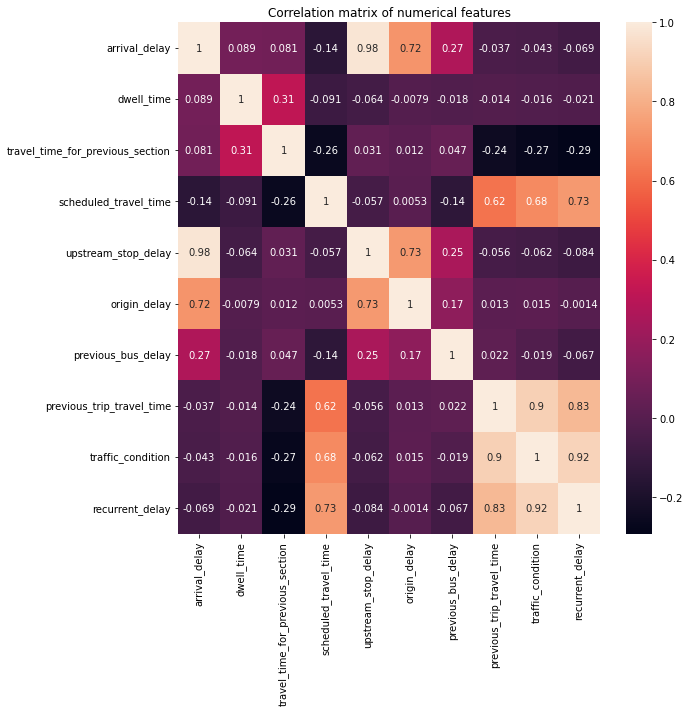

In [8]:
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)
plt.subplots(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation matrix of numerical features")
plt.tight_layout()
plt.show()

From the above correlation matrix, it looks like the strongest variables that influence arrival_delay are:\
upstream_stop_delay and origin_delay.\
recurrent_delay has a strong influence with traffic_condition, previous_trip_travel_time and schedule_travel_time.

In [9]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# sns.histplot(x=df['arrival_delay'])

In [10]:
# max_delay_row = df[df['arrival_delay'] == df['arrival_delay'].max()]
# print(max_delay_row)

In [11]:
# Extract only 'Weekdays' from day_of_week to train
# Filter the data
df_weekday = df[df['day_of_week'] == 'weekday']
df_weekend = df[df['day_of_week'] == 'weekend']

print(df_weekday.shape)
print(df_weekend.shape)

(418149, 12)
(126954, 12)


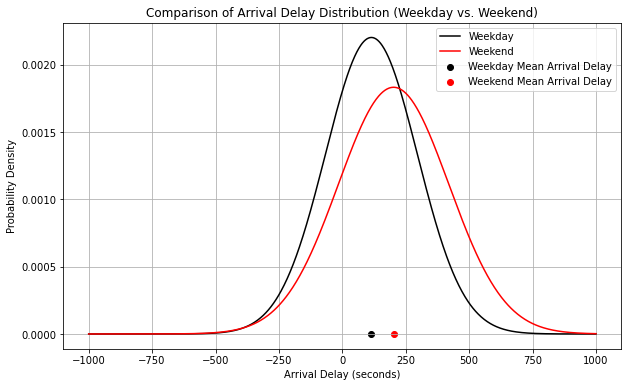

In [12]:
from scipy.stats import norm

# Extract 'arrival_delay' data for both datasets
arrival_delay_weekday = df_weekday['arrival_delay']
arrival_delay_weekend = df_weekend['arrival_delay']

# Calculate mean and standard deviation for each dataset
mean_weekday = arrival_delay_weekday.mean()
std_dev_weekday = arrival_delay_weekday.std()
mean_weekend = arrival_delay_weekend.mean()
std_dev_weekend = arrival_delay_weekend.std()

# Generate x values for the probability density functions (PDFs)
x = np.linspace(-1000, 1000, 1000)

# Calculate PDFs for the normal distributions
pdf_weekday = norm.pdf(x, loc=mean_weekday, scale=std_dev_weekday)
pdf_weekend = norm.pdf(x, loc=mean_weekend, scale=std_dev_weekend)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the PDFs for both datasets
plt.plot(x, pdf_weekday, label='Weekday', color='black')
plt.plot(x, pdf_weekend, label='Weekend', color='red')

# Add dots for the mean arrival delays
plt.scatter([mean_weekday], [0], color=['black'], marker='o', label='Weekday Mean Arrival Delay')
plt.scatter([mean_weekend], [0], color=['red'], marker='o', label='Weekend Mean Arrival Delay')

plt.xlabel('Arrival Delay (seconds)')
plt.ylabel('Probability Density')
plt.title('Comparison of Arrival Delay Distribution (Weekday vs. Weekend)')
plt.legend()
plt.grid(True)

#plt.grid(False)
plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_delay                     545103 non-null  int64  
 1   dwell_time                        545103 non-null  int64  
 2   travel_time_for_previous_section  545103 non-null  int64  
 3   scheduled_travel_time             545103 non-null  int64  
 4   upstream_stop_delay               545103 non-null  int64  
 5   origin_delay                      545103 non-null  int64  
 6   previous_bus_delay                545103 non-null  int64  
 7   previous_trip_travel_time         545103 non-null  int64  
 8   traffic_condition                 545103 non-null  float64
 9   recurrent_delay                   545103 non-null  float64
 10  day_of_week                       545103 non-null  object 
 11  time_of_day                       545103 non-null  o

# Model 1: Weekday Model
Using only data during weekdays and specified particular variables

### Regression 

In [22]:
from sklearn.model_selection import cross_val_score
# Define Independent and dependent variables
x = df_weekday.drop(['arrival_delay', 'day_of_week', 'traffic_condition', 'recurrent_delay', 'time_of_day' ], axis=1)
y = df_weekday['arrival_delay']

# Miltiple Linear Regression Model
model_1R = LinearRegression()
# Try corss validation score first
# cross_val_score(model_1, x, y, cv=5).mean()

#### Training and Prediction

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model_1R.fit(x_train, y_train)

y_pred = model_1R.predict(x_test)

#### Evaluate Model 1

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 16.013192904937807
Mean Squared Error: 551.0793299584448
R-squared: 0.9832203161650983


#### Visualize the results

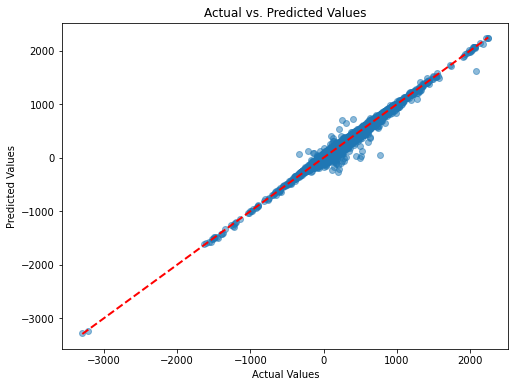

In [25]:
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### Other models: SVM, XGBoost and NN

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier

# Model 1: Support Vector Machine (SVM)
model_1SVM = SVC()
param_grid_1 = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
}

# Model 2: XGBoost Classifier (for regression tasks, use XGBRegressor)
model_1XGB = XGBClassifier()
param_grid_2 = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
}

# Model 3: Sequential Neural Network
model_1NN = Sequential()
model_1NN.add(Dense(32, activation='relu', input_dim=x.shape[1]))
model_1NN.add(Dropout(rate=0.1))
model_1NN.add(Dense(64, activation='relu'))
model_1NN.add(Dense(1))  
param_grid_3 = {
    'epochs': [10, 20, 30, 200, 500],
    'batch_size': [32, 64, 128, 253],
}

models = [model_1SVM, model_1XGB, model_1NN]
param_grids = [param_grid_1, param_grid_2, param_grid_3]

# Loop through the models and perform GridSearchCV
for i, (model, param_grid) in enumerate(zip(models, param_grids)):
    print(f"Model {i + 1} - {model.__class__.__name__}")
    
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    # Perform GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(x_train, y_train)
    
    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)

In [ ]:
# Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Fit the best model to the training data
    best_model.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = best_model.predict(x_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print()

# Model 2: Weekend Model
Using only data during weekdays and specified particular variables